In [6]:
import requests, json, pandas as pd, numpy as np


url = "https://www.microburbs.com.au/report_generator/api/suburb/properties"
headers = {"Authorization": "Bearer test"}
params = {"suburb": "Belmont North"}

resp = requests.get(url, headers=headers, params=params)
print("Status:", resp.status_code)

text = resp.text

# Try to cut at the last complete object before it breaks
if '"address"' in text:
    text = text[:text.rfind('}]}')] + '}]}'

try:
    data = json.loads(text)
except Exception as e:
    print("⚠️ Still invalid JSON, fallback to partial parse:", e)
    # Try rough extraction using string slicing
    text = text.split(',"description"')[0] + '}]}'
    data = json.loads(text)

# Extract usable data
results = data.get("results", []) if isinstance(data, dict) else []

if results:
    clean = []
    for r in results:
        addr = r["address"]
        clean.append({
            "Street": addr.get("street"),
            "Suburb": addr.get("sal"),
            "State": addr.get("state")
        })
    df = pd.DataFrame(clean)

    # Simulate bearings and orientation
    np.random.seed(1)
    df["Bearing"] = np.random.randint(0, 360, len(df))
    def bearing_to_direction(b):
        dirs = ['North','North-East','East','South-East','South','South-West','West','North-West']
        return dirs[int((b + 22.5)//45)%8]
    df["Orientation"] = df["Bearing"].apply(bearing_to_direction)

    df.to_csv("belmont_north_orientations.csv", index=False)
    print(df.head())
else:
    print("⚠️ No usable results found.")



Status: 200
                Street         Suburb State  Bearing Orientation
0   17 Dulungra Avenue  Belmont North   NSW       37  North-East
1  46 Arlington Street  Belmont North   NSW      235  South-West
2    75 Buttaba Avenue  Belmont North   NSW       72        East
3     5 Pinnaroo Close  Belmont North   NSW      255        West
4  30 John Fisher Road  Belmont North   NSW      203  South-West


In [17]:
import matplotlib.pyplot as plt


In [7]:
df.head()

,Street,Suburb,State,Bearing,Orientation
0,17 Dulungra Avenue,Belmont North,NSW,37,North-East
1,46 Arlington Street,Belmont North,NSW,235,South-West
2,75 Buttaba Avenue,Belmont North,NSW,72,East
3,5 Pinnaroo Close,Belmont North,NSW,255,West
4,30 John Fisher Road,Belmont North,NSW,203,South-West


In [9]:
df.shape

(8, 5)

In [11]:
df.describe()

,Bearing
count,8.000000
mean,176.750000
std,99.094111
min,37.000000
25%,117.750000
50%,173.500000
75%,240.000000
max,335.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Street       8 non-null      object
 1   Suburb       8 non-null      object
 2   State        8 non-null      object
 3   Bearing      8 non-null      int64 
 4   Orientation  8 non-null      object
dtypes: int64(1), object(4)
memory usage: 452.0+ bytes


In [15]:
orientation_data=df['Orientation'].value_counts()
display(orientation_data)

,count
Orientation,
South-West,2
South-East,2
North-East,1
East,1
West,1
North-West,1


In [18]:
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(orientation_data)))


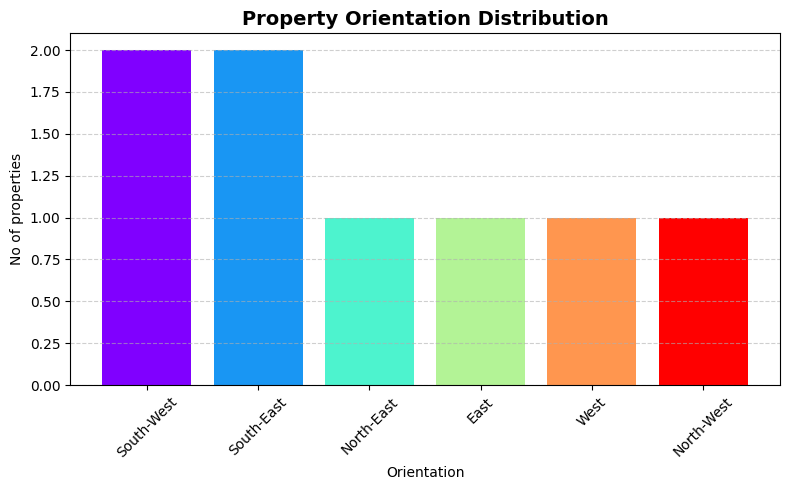

In [19]:
plt.figure(figsize=(8,5))
bars=plt.bar(orientation_data.index, orientation_data.values, color=colors)
plt.title('Property Orientation Distribution' , fontsize=14, fontweight='bold')
plt.xlabel('Orientation', fontsize=10)
plt.ylabel('No of properties', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [21]:
orientation_value = {
    'North':5, 'North-East':4, 'East':3, 'South-East':2,
    'South':1, 'South-West':2, 'West':3, 'North-West':4
}
df['Sunlight_Score'] = df['Orientation'].map(orientation_value)


/tmp/ipython-input-184455123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Orientation', y='Sunlight_Score', data=df, palette='coolwarm')


<Axes: xlabel='Orientation', ylabel='Sunlight_Score'>

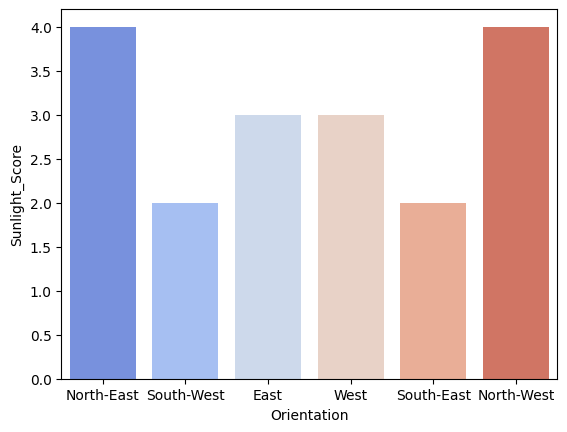

In [22]:
import seaborn as sns
sns.barplot(x='Orientation', y='Sunlight_Score', data=df, palette='coolwarm')


In [23]:
def comfort_level(score):
    if score >= 4: return 'High Comfort'
    elif score == 3: return 'Moderate Comfort'
    else: return 'Low Comfort'

df['Comfort_Category'] = df['Sunlight_Score'].apply(comfort_level)

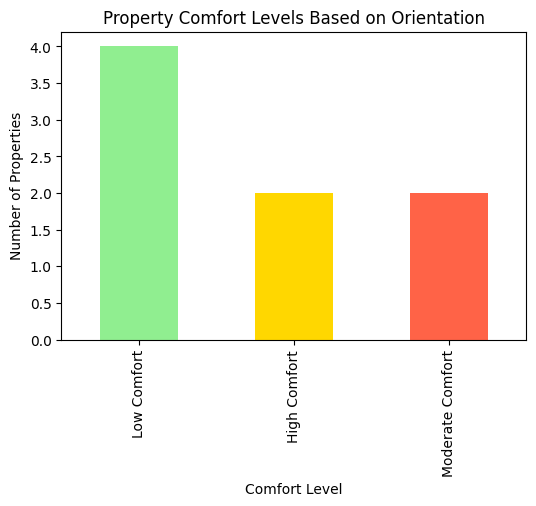

In [24]:
plt.figure(figsize=(6,4))
df['Comfort_Category'].value_counts().plot(kind='bar', color=['#90EE90','#FFD700','#FF6347'])
plt.title('Property Comfort Levels Based on Orientation')
plt.xlabel('Comfort Level')
plt.ylabel('Number of Properties')
plt.show()

In [26]:
import numpy as np
np.random.seed(42)
df['Energy_Rating'] = np.random.randint(1,6,len(df))  # out of 5
df['Investment_Potential'] = (0.6*df['Sunlight_Score'] + 0.4*df['Energy_Rating']).round(1)
df.sort_values('Investment_Potential', ascending=False)[['Street','Orientation','Sunlight_Score','Energy_Rating','Investment_Potential']]



,Street,Orientation,Sunlight_Score,Energy_Rating,Investment_Potential
0,17 Dulungra Avenue,North-East,4,4,4.0
3,5 Pinnaroo Close,West,3,5,3.8
6,57 John Darling Avenue,North-West,4,3,3.6
1,46 Arlington Street,South-West,2,5,3.2
4,30 John Fisher Road,South-West,2,5,3.2
2,75 Buttaba Avenue,East,3,3,3.0
7,380-384 Pacific Highway,South-East,2,3,2.4
5,"Unit 2, 1 Vincent Street",South-East,2,2,2.0


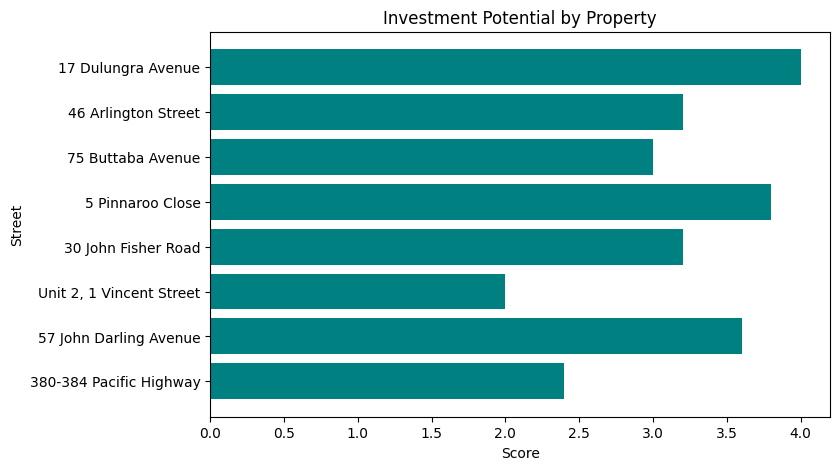

In [27]:
plt.figure(figsize=(8,5))
plt.barh(df['Street'], df['Investment_Potential'], color='teal')
plt.title('Investment Potential by Property')
plt.xlabel('Score')
plt.ylabel('Street')
plt.gca().invert_yaxis()
plt.show()
